In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np


In this Notebook, we are going to implement CNN Models: UNet and SegNet. Both of these models are very influential in semantic segmentaion and image classification.
We have used Tensorflow to implement the models.

In [ ]:
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

Another very important library imported is **Scikit-Image (skimage)**. It is very important for the image analysis and encoding the image into machine-readable form and decoding it to reform the image.

In [ ]:
hght= 128
width= 128
channel= 3 # RGB

The image height, width and number of channels have been specified as 128, 128 and 3 respectively. Height and Width have been set to 128 pixels each and Number of Channels as 3 (Red, Green and Blue).

In [ ]:
tr_path = '/kaggle/input/frames/frames'
tr_id = next(os.walk(tr_path))[2]
ts_path = '/kaggle/input/masks123/masks'
ts_id = next(os.walk(tr_path))[2]

In [ ]:
X = np.zeros((len(tr_id),hght,width, channel), dtype=np.uint8)
Y = np.zeros((len(ts_id),hght,width, 1), dtype=bool)

The frames and masks are respectively appended in the X and Y numpy arrays. X is the input (Frame) and Y is the output (Mask).

In [ ]:
for n, ID in tqdm(enumerate(tr_id), total=len(tr_id)):
    final_path= tr_path + '/' +ID
    img= imread(final_path)[:,:,:channel]
    img= resize(img, (hght, width), mode='constant', preserve_range = True )
    X[n]= img

100%|██████████| 2729/2729 [01:39<00:00, 27.38it/s]


In [ ]:
for n, ID in tqdm(enumerate(ts_id), total=len(ts_id)):
    final_path= ts_path +'/'+ ID
    img= imread(final_path)[:,:,:1]
    img= resize(img, (hght, width), mode='constant', preserve_range = True )
    Y[n]= img

100%|██████████| 2729/2729 [00:44<00:00, 61.94it/s]


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.2, random_state=42)#train test split of 20%

In [ ]:
Xtr = tf.cast(X_tr, tf.float32)
Xts = tf.cast(X_ts, tf.float32)
Ytr= tf.cast(Y_tr, tf.float32)
Yts= tf.cast(Y_ts, tf.float32)

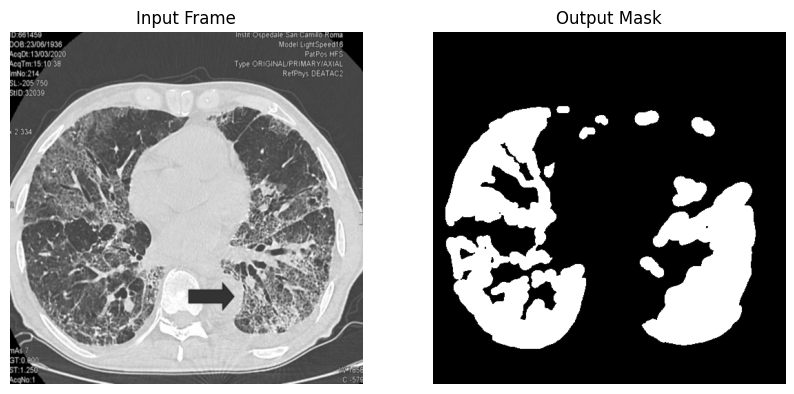

In [ ]:
import matplotlib.image as mpimg

x = mpimg.imread('/kaggle/input/frames/frames/bjorke_2.png')
y = mpimg.imread('/kaggle/input/masks123/masks/bjorke_2.png')
plt.figure(figsize=(10, 5))
# First image
plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title('Input Frame')
plt.axis('off')
# Second image
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title('Output Mask')
plt.axis('off')

plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, BatchNormalization
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K

In [ ]:
def intersection(ytrue, ypred, axis=[1, 2, 3]):
    inter = tf.multiply(ytrue, ypred)
    inter = tf.reduce_sum(inter, axis=axis)
    return inter

In [ ]:
def union(y_true, y_pred, axis=[1, 2, 3]):
    un = tf.add(y_true, y_pred)
    un = tf.reduce_sum(un, axis=axis)
    return un

In [ ]:
def dice_coefficient(ytrue, ypred, smooth=1e-8):
    inter = tf.multiply(ytrue,ypred)
    un = tf.add(ytrue,ypred)
    dice = (2.0 * inter + smooth) / (un + smooth)
    return K.mean(dice)

In [ ]:
def dice_loss(ytrue,ypred):
    return 1-dice_coefficient(ytrue,ypred)

In [ ]:
def combined_loss(ytrue,ypred):
    return binary_crossentropy(ytrue,ypred)+dice_loss(ytrue,ypred)

We create Custom Loss Function Using Negative Log Likelihood and Dice Loss

**UNET**

In [ ]:
def unet(hght, width, channel):
    inputs = Input((hght, width, channel))
    s = Lambda(lambda x: x / 255)(inputs)   # Normalization of our inputs ( Pixels range from 0 to 255 )
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=combined_loss, metrics=[dice_coefficient])
    model.summary()

    return model

In [ ]:
model=unet(hght,width,channel)
model.fit(Xtr,Ytr,epochs=10,batch_size=32)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 128, 128, 16)         448       ['input_4[0][0]']             
                                                                                                  
 dropout_27 (Dropout)        (None, 128, 128, 16)         0         ['conv2d_57[0][0]']           
                                                                                                  
 conv2d_58 (Conv2D)          (None, 128, 128, 16)         2320      ['dropout_27[0][0]']          
                                                                                            

In [ ]:
y_pred = model.predict(Xts)

18/18 [==============================] - 10s 558ms/step


In [ ]:
dice_coefficient(Yts,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.85280454>

**SEGNET**

In [ ]:
def segnet(hght,width,channel):
    inputs = Input((hght, width, channel))
    s = Lambda(lambda x: x / 255)(inputs)   # Normalization of our inputs ( Pixels range from 0 to 255 )
    s = inputs

    #Contraction path(Encoder)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansion path(Decoder)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=combined_loss, metrics=[dice_coefficient])
    model.summary()

    return model

In [ ]:
model=segnet(hght,width,channel)
model.fit(Xtr,Ytr,epochs=10,batch_size=32)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_76 (Conv2D)          (None, 128, 128, 16)         448       ['input_5[0][0]']             
                                                                                                  
 dropout_36 (Dropout)        (None, 128, 128, 16)         0         ['conv2d_76[0][0]']           
                                                                                                  
 conv2d_77 (Conv2D)          (None, 128, 128, 16)         2320      ['dropout_36[0][0]']          
                                                                                            

In [ ]:
y_pred = model.predict(Xts)

18/18 [==============================] - 12s 654ms/step


In [ ]:
dice_coefficient(Yts,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8209368>

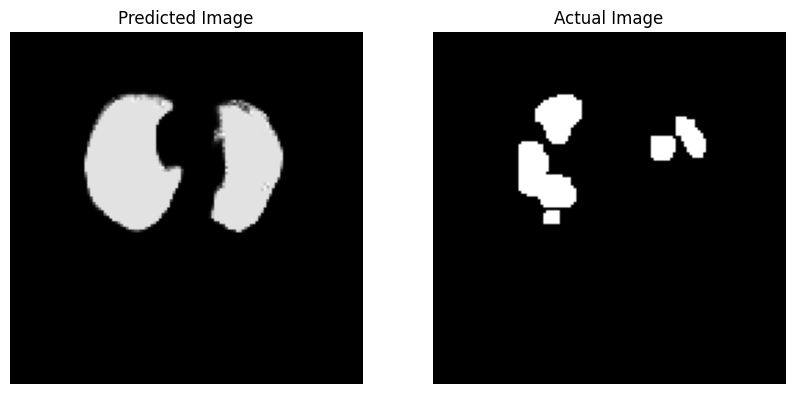

In [ ]:
#A random example
x = y_pred[264]
y = Y_test[264]

plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')  # 'Gray' colormap for grayscale images
plt.title('Predicted Image')
plt.axis('off')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')  # 'Gray' colormap for grayscale images
plt.title('Actual Image')
plt.axis('off')

plt.show()

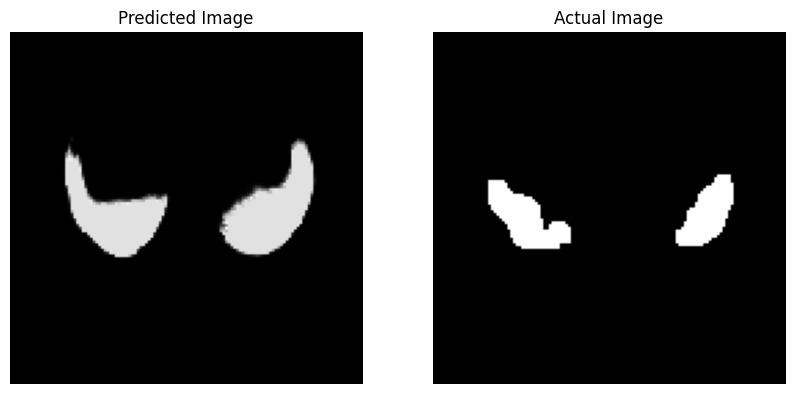

In [ ]:
#Another random example
x = y_pred[252]
y = Y_test[252]

plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')  # 'Gray' colormap for grayscale images
plt.title('Predicted Image')
plt.axis('off')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')  # 'Gray' colormap for grayscale images
plt.title('Actual Image')
plt.axis('off')

plt.show()